# Install Detectron2 Dependencies

In [ ]:
!python -m pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
exit(0)

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-bpotny2l
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-bpotny2l
  Resolved https://github.com/facebookresearch/detectron2.git to commit 017abbfa5f2c2a2afa045200c2af9ccf2fc6227f
  Preparing metadata (setup.py) ... done


In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

# Import and Register Custom Detectron2 Dataset from Roboflow

In [ ]:
!curl -L "https://public.roboflow.com/ds/tARhGryd3k?key=yhHJWCEP5K" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   892  100   892    0     0    873      0  0:00:01  0:00:01 --:--:--   874
100 46.4M  100 46.4M    0     0  28.5M      0  0:00:01  0:00:01 --:--:-- 28.5M
Archive:  roboflow.zip
replace README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: test/_annotations.coco.json  
 extracting: test/img-105_jpg.rf.3fe9dff3d1631e79ecb480ff403bcb86.jpg  
 extracting: test/img-107_jpg.rf.2e40485785f6e5e2efec404301b235c2.jpg  
 extracting: test/img-146_jpg.rf.61be25b3053a51f622a244980545df2b.jpg  
 extracting: test/img-161_jpg.rf.211541e7178a4a93ec0680f26b905427.jpg  
 extracting: test/img-168_jpg.rf.af3590e07b06b43e91fa53990ff94af3.jpg  
 extracting: test/img-179_jpg.rf.8632eb0d9b75fefe144829e67b75015a.jpg  
 extracting: test/img-195_jpg.rf.f77a8f4d4

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")


WARNING [11/24 19:55:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/24 19:55:51 d2.data.datasets.coco]: Loaded 465 images in COCO format from /content/train/_annotations.coco.json


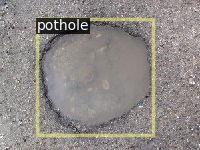

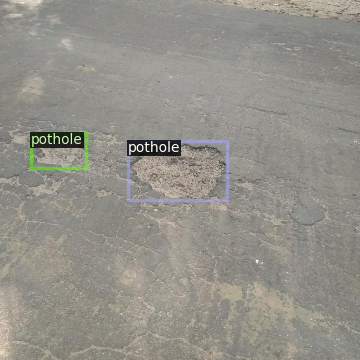

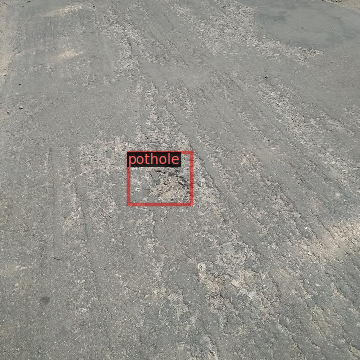

In [ ]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Train Custom Detectron2 Detector

In [ ]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cfg = get_cfg()
cfg.OUTPUT_DIR = "drive/MyDrive/FAST-RCNN"
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/fast_rcnn_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/fast_rcnn_R_50_FPN_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.01


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 500 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

cfg.TEST.EVAL_PERIOD = 50

In [ ]:
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[11/24 20:00:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [ ]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./content/gdrive/My Drive/V1/")#"./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

[11/24 20:10:02 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from drive/MyDrive/FAST-RCNN/model_final.pth ...
WARNING [11/24 20:10:02 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [11/24 20:10:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/24 20:10:02 d2.data.datasets.coco]: Loaded 67 images in COCO format from /content/test/_annotations.coco.json
[11/24 20:10:02 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|  potholes  | 0            |  pothole   | 154          |
|            |              |            |              |
|   total    | 154          |            |              |
[11/24 20:10:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations u

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[11/24 20:10:04 d2.evaluation.evaluator]: Inference done 11/67. Dataloading: 0.0047 s/iter. Inference: 0.1025 s/iter. Eval: 0.0004 s/iter. Total: 0.1075 s/iter. ETA=0:00:06
[11/24 20:10:09 d2.evaluation.evaluator]: Inference done 56/67. Dataloading: 0.0055 s/iter. Inference: 0.1050 s/iter. Eval: 0.0004 s/iter. Total: 0.1110 s/iter. ETA=0:00:01
[11/24 20:10:10 d2.evaluation.evaluator]: Total inference time: 0:00:06.838566 (0.110299 s / iter per device, on 1 devices)
[11/24 20:10:10 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:06 (0.103624 s / iter per device, on 1 devices)
[11/24 20:10:10 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[11/24 20:10:10 d2.evaluation.coco_evaluation]: Saving results to ./content/gdrive/My Drive/V1/coco_instances_results.json
[11/24 20:10:10 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[11/24 20:1

OrderedDict([('bbox',
              {'AP': 32.79563798808785,
               'AP50': 59.18580582378611,
               'AP75': 30.355892803287688,
               'APs': 28.654144569751466,
               'APm': 23.497170192568145,
               'APl': 44.11359846254857,
               'AP-potholes': nan,
               'AP-pothole': 32.79563798808785})])

# Inference with Detectron2 Saved Weights



In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

[11/24 20:10:25 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from drive/MyDrive/FAST-RCNN/model_final.pth ...


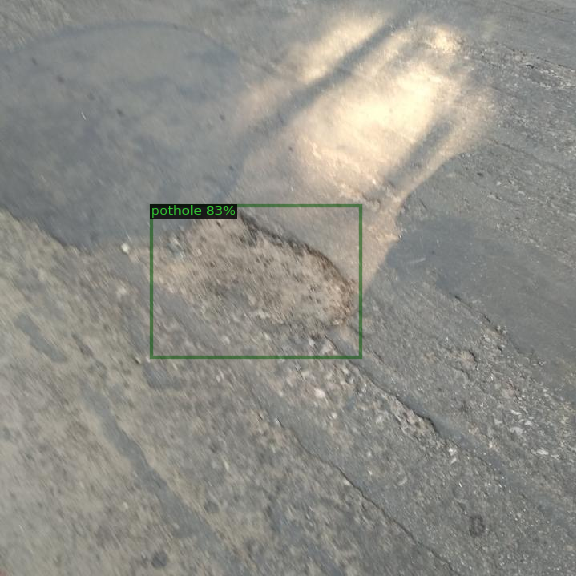

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

# for imageName in glob.glob('/content/test/*jpg'):
imageName = '/content/test/img-146_jpg.rf.61be25b3053a51f622a244980545df2b.jpg'
im = cv2.imread(imageName)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata=test_metadata, scale=0.8)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])
